In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from PIL import Image
import os
# import torch.functional as F
import torch.nn.functional as F

Training samples: 9000
Validation samples: 1000
torch.Size([1, 150, 150])


/home/vimarsh/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


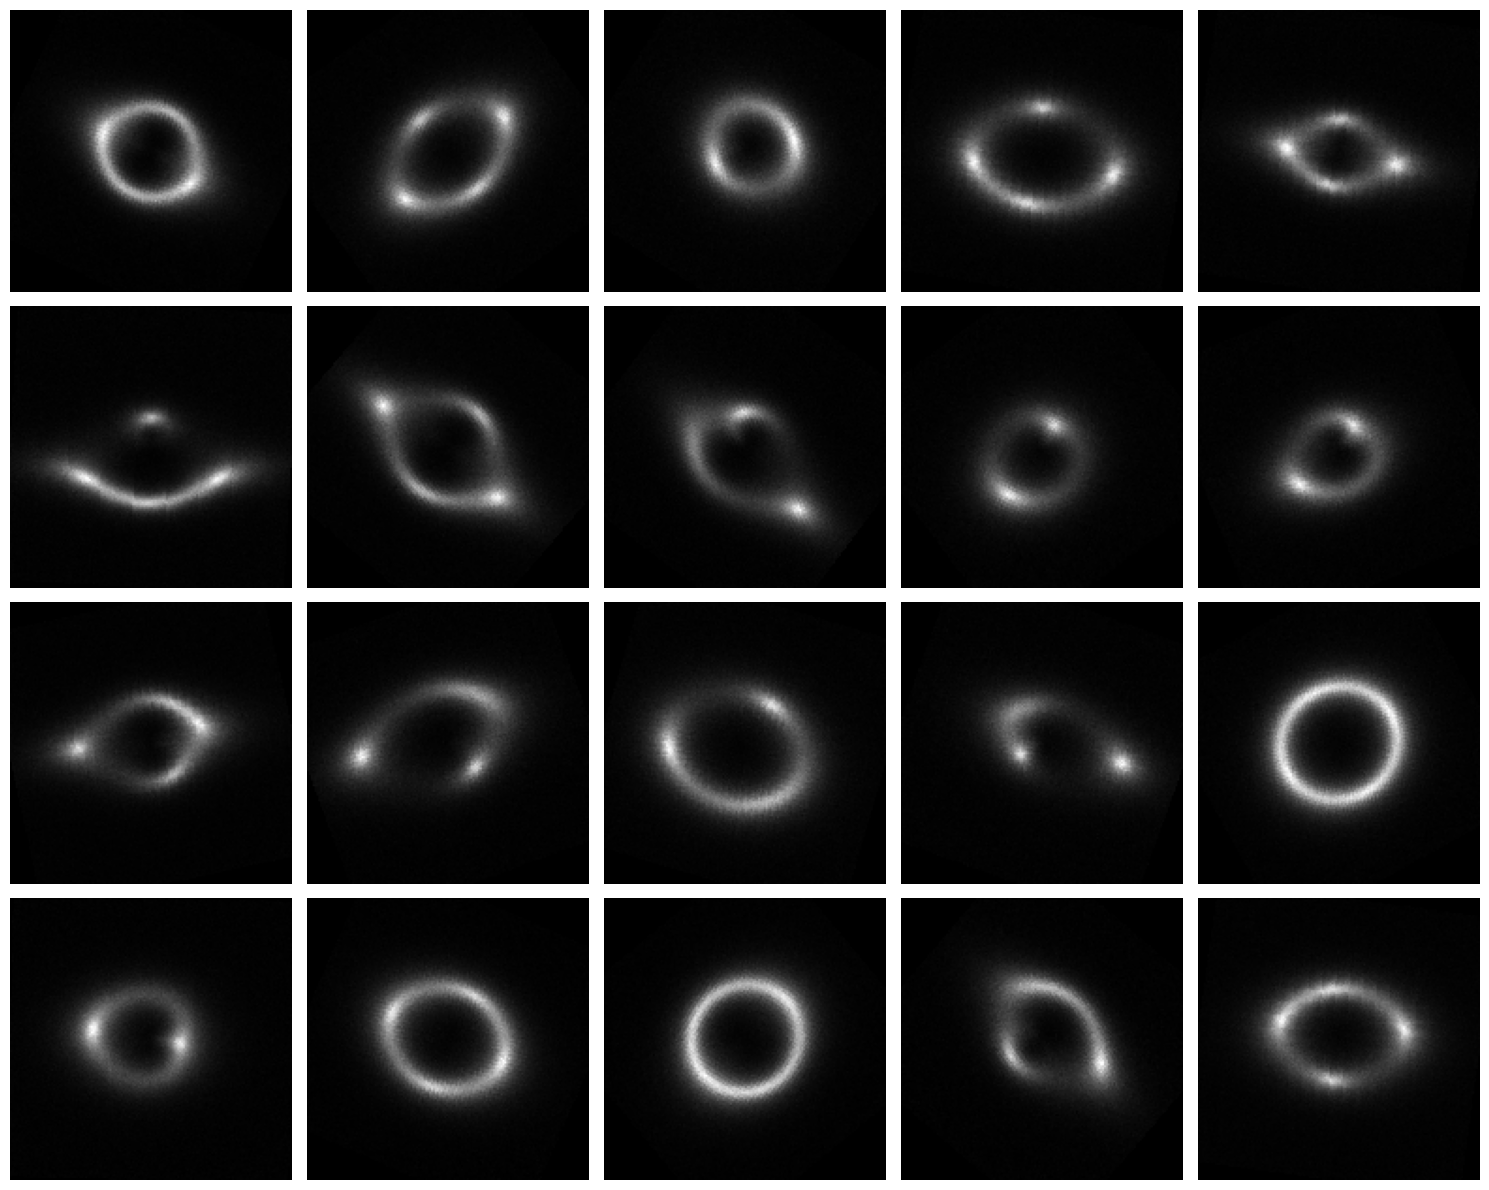

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
class NpyImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        Args:
            data_dir (string): Directory with all the .npy image files
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.data_dir = data_dir
        self.transform = transform
        
        # Get all .npy files
        self.image_paths = glob.glob(os.path.join(data_dir, '*.npy'))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = np.load(self.image_paths[idx])
        
        # Convert to torch tensor
        image = torch.from_numpy(image).float()
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

# Create dataset
dataset = NpyImageDataset(data_dir='/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/Diffusion_Samples/Samples', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
dataset_train, dataset_val = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_val)}")

print(dataset_train[0].shape)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4)

#randomly plotting some images
import matplotlib.pyplot as plt
import numpy
import random
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()
for i in range(20):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx]
    img = img.permute(1, 2, 0)
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(SimpleUNet, self).__init__()
        # Encoder: two convolutional layers with downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        # Decoder: two transposed convolutional layers to upsample
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(features, out_channels, kernel_size=4, stride=2, padding=1)
        )
        # Time embedding: a simple linear layer to embed t (normalized between 0 and 1)
        self.time_embed = nn.Sequential(
            nn.Linear(1, features * 2),
            nn.ReLU(),
            nn.Linear(features * 2, features * 2)  # Ensure output matches encoder feature size
        )

    def forward(self, x, t):
        # x shape: [B, 1, 150, 150]; t shape: [B, 1] (normalized timestep)
        t_emb = self.time_embed(t)  # shape: [B, features*2]
        encoded = self.encoder(x)  # shape: [B, features*2, H', W']
        # Expand time embedding to match spatial dimensions of encoded features
        t_emb = t_emb.view(t_emb.size(0), t_emb.size(1), 1, 1)  # shape: [B, features*2, 1, 1]
        encoded = encoded + t_emb  # Inject time information into encoded features
        decoded = self.decoder(encoded)  # output shape: [B, 1, 150, 150]
        decoded = decoded[:, :, :x.size(2), :x.size(3)]
        return decoded


In [5]:
def get_noise_schedule(T, beta_start=0.0001, beta_end=0.02):
    # Linear schedule from beta_start to beta_end over T steps
    return torch.linspace(beta_start, beta_end, T)

def compute_alphas(betas):
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return alphas, alphas_cumprod


In [6]:
T_steps = 1000  
betas = get_noise_schedule(T_steps).to(device)
alphas, alphas_cumprod = compute_alphas(betas)
sqrt_alphas_cumprod = alphas_cumprod.sqrt().to(device)
sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod).sqrt().to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet(in_channels=1, out_channels=1, features=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 1000

In [7]:
model.train()
import tqdm
for epoch in range(num_epochs):
    for images in train_loader:
        images = images.to(device)  # images.shape: [B, 1, 150, 150]
        batch_size = images.size(0)
        
        # Sample random integer timesteps for each image and normalize to [0,1]
        t_int = torch.randint(0, T_steps, (batch_size,), device=device)
        t_norm = (t_int.float() / T_steps).unsqueeze(1)  # shape: [B, 1]
        
        # Sample noise with the same shape as images
        noise = torch.randn_like(images)
        
        # Gather corresponding scale coefficients using sampled timesteps
        sqrt_alphas = sqrt_alphas_cumprod[t_int].view(batch_size, 1, 1, 1)
        sqrt_one_minus_alphas = sqrt_one_minus_alphas_cumprod[t_int].view(batch_size, 1, 1, 1)
        
        # Create noised images x_t using the forward diffusion process
        x_t = sqrt_alphas * images + sqrt_one_minus_alphas * noise
        
        # Predict noise using the model (passing in x_t and the normalized timestep)
        noise_pred = model(x_t, t_norm)
        
        # Loss is the MSE between predicted noise and the true noise
        loss = F.mse_loss(noise_pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/1000, Loss: 0.9357
Epoch 2/1000, Loss: 0.7905
Epoch 3/1000, Loss: 0.6058
Epoch 4/1000, Loss: 0.4536
Epoch 5/1000, Loss: 0.3589
Epoch 6/1000, Loss: 0.2781
Epoch 7/1000, Loss: 0.1291
Epoch 8/1000, Loss: 0.1899
Epoch 9/1000, Loss: 0.1121
Epoch 10/1000, Loss: 0.1803
Epoch 11/1000, Loss: 0.1290
Epoch 12/1000, Loss: 0.1241
Epoch 13/1000, Loss: 0.1175
Epoch 14/1000, Loss: 0.1212
Epoch 15/1000, Loss: 0.1516
Epoch 16/1000, Loss: 0.1131
Epoch 17/1000, Loss: 0.0930
Epoch 18/1000, Loss: 0.1399
Epoch 19/1000, Loss: 0.0876
Epoch 20/1000, Loss: 0.1121
Epoch 21/1000, Loss: 0.1079
Epoch 22/1000, Loss: 0.0778
Epoch 23/1000, Loss: 0.1117
Epoch 24/1000, Loss: 0.0537
Epoch 25/1000, Loss: 0.0591
Epoch 26/1000, Loss: 0.0612
Epoch 27/1000, Loss: 0.0694
Epoch 28/1000, Loss: 0.0948
Epoch 29/1000, Loss: 0.1421
Epoch 30/1000, Loss: 0.0502
Epoch 31/1000, Loss: 0.0555
Epoch 32/1000, Loss: 0.0965
Epoch 33/1000, Loss: 0.0429
Epoch 34/1000, Loss: 0.0695
Epoch 35/1000, Loss: 0.0317
Epoch 36/1000, Loss: 0.0714
E

KeyboardInterrupt: 

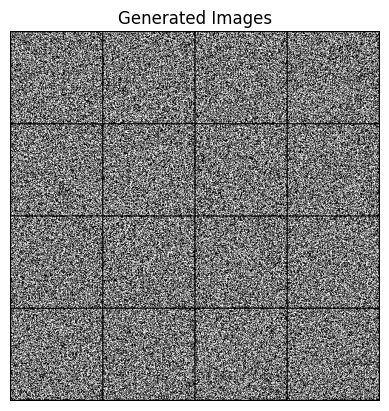

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.models import inception_v3
import torchvision.transforms as transforms
import numpy as np
from scipy.linalg import sqrtm

def visualize_generated_images(model, num_images=16, image_size=(150, 150), device='cuda'):
    """
    Generates images from the diffusion model and visualizes them on a grid.
    Assumes the model produces 1-channel images in the range [-1, 1].
    
    Args:
        model: Trained diffusion model supporting sampling.
        num_images: Number of images to generate.
        image_size: Spatial dimensions of generated images.
        device: Device to run the computations on.
    """
    model.eval()
    with torch.no_grad():
        # Create noise tensor with shape (num_images, 1, H, W)
        noise = torch.randn((num_images, 1, *image_size), device=device)
        # For demonstration, we assume the model’s sampling process is invoked via
        # model(noise, t) with a dummy timestep (here t=0) across the batch.
        dummy_t = torch.zeros((num_images, 1), device=device)
        generated_images = model(noise, dummy_t)
    
    # Scale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2
    generated_images = torch.clamp(generated_images, 0, 1)
    
    # Create a grid. For single-channel images, squeeze the channel for display.
    grid = make_grid(generated_images, nrow=4)
    grid_np = grid.permute(1, 2, 0).cpu().numpy()
    
    # If the grid has one channel, display as grayscale
    if grid_np.shape[2] == 1:
        grid_np = grid_np.squeeze(-1)
        plt.imshow(grid_np, cmap='gray')
    else:
        plt.imshow(grid_np)
    
    plt.axis('off')
    plt.title('Generated Images')
    plt.show()


def get_inception_features(images, inception, device):
    """
    Extracts features from images using a pretrained InceptionV3 network.
    Since Inception expects 3-channel input, replicate grayscale images.
    
    Args:
        images: Tensor [N, 1, H, W] with values in [0, 1].
        inception: Pre-trained InceptionV3 network.
        device: Computation device.
        
    Returns:
        Numpy array of extracted features.
    """
    inception.eval()
    resize = transforms.Resize((299, 299))
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    features = []

    for i in range(images.size(0)):
        img = images[i]  # shape: (1, H, W)
        # Replicate channel if image is grayscale
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        img = resize(img.cpu())
        img = norm(img).unsqueeze(0).to(device)  # shape: (1, 3, 299, 299)
        with torch.no_grad():
            feat = inception(img)
        features.append(feat.squeeze().cpu().numpy())
    features = np.array(features)
    return features

def compute_fid(real_images, generated_images, device='cuda'):
    """
    Computes the Fréchet Inception Distance (FID) between real and generated images.
    The images should be in [0, 1] range. Single-channel images are converted to 3-channel.
    
    Args:
        real_images: Tensor [N, 1, H, W] for real images.
        generated_images: Tensor [N, 1, H, W] for generated images.
        device: Computation device.
        
    Returns:
        FID score (lower is better).
    """
    # Initialize InceptionV3 model. Removing the final fully-connected layer.
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = torch.nn.Identity()
    inception = inception.to(device)
    inception.eval()
    
    # Extract features from real images
    real_features = get_inception_features(real_images, inception, device)
    # Extract features from generated images
    gen_features = get_inception_features(generated_images, inception, device)
    
    # Calculate statistics
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    mu_gen = np.mean(gen_features, axis=0)
    sigma_gen = np.cov(gen_features, rowvar=False)
    
    # Compute FID using the formula
    diff = mu_real - mu_gen
    diff_squared = diff.dot(diff)
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff_squared + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

def evaluate_fid(model, real_dataloader, num_batches=10, image_size=(150, 150), device='cuda'):
    """
    Evaluates the model by computing the FID over a subset of real images and generated images.
    
    Args:
        model: Trained diffusion model.
        real_dataloader: DataLoader providing batches of real 1-channel images.
        num_batches: Number of batches to use for evaluation.
        image_size: Size of the generated images.
        device: Computation device.
    
    Returns:
        FID score.
    """
    model.eval()
    real_features_list = []
    gen_features_list = []
    # Prepare the Inception model, as before
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = torch.nn.Identity()
    inception = inception.to(device)
    inception.eval()

    # Transformation for Inception network input
    inception_transform = transforms.Compose([
        transforms.Resize((299, 299)),
        # Conversion to 3 channels if needed is handled below
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    count = 0
    # Process real images
    for images, _ in real_dataloader:
        if count >= num_batches:
            break
        images = images.to(device)
        # Convert each image to 3 channels if necessary
        processed_real = []
        for img in images:
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            img = inception_transform(img.cpu())
            processed_real.append(img)
        real_batch_proc = torch.stack(processed_real).to(device)  # (B, 3, 299, 299)
        
        with torch.no_grad():
            feats = inception(real_batch_proc).detach().cpu().numpy()
        real_features_list.append(feats)
        count += 1
    
    real_features = np.concatenate(real_features_list, axis=0)
    
    count = 0
    # Generate images and extract features
    for images, _ in real_dataloader:
        if count >= num_batches:
            break
        batch_size = images.size(0)
        with torch.no_grad():
            noise = torch.randn((batch_size, 1, *image_size), device=device)
            dummy_t = torch.zeros((batch_size, 1), device=device)
            gen_batch = model(noise, dummy_t)
            gen_batch = (gen_batch + 1) / 2
            gen_batch = torch.clamp(gen_batch, 0, 1)
        
        processed_gen = []
        for img in gen_batch:
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
            img = inception_transform(img.cpu())
            processed_gen.append(img)
        gen_batch_proc = torch.stack(processed_gen).to(device)
        
        with torch.no_grad():
            feats = inception(gen_batch_proc).detach().cpu().numpy()
        gen_features_list.append(feats)
        count += 1
    
    gen_features = np.concatenate(gen_features_list, axis=0)
    
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    mu_gen = np.mean(gen_features, axis=0)
    sigma_gen = np.cov(gen_features, rowvar=False)
    
    diff = mu_real - mu_gen
    diff_squared = diff.dot(diff)
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_value = diff_squared + np.trace(sigma_real + sigma_gen - 2 * covmean)
    
    return fid_value

# Visualize generated images
visualize_generated_images(model, num_images=16, image_size=(150, 150), device=device)

# Compute FID score over a few batches of the real dataset
# fid_score = evaluate_fid(model, train_loader, num_batches=10, image_size=(150, 150), device=device)
# print(f"FID Score: {fid_score:.4f}")


In [ ]:
fid_score = evaluate_fid(model, train_loader, num_batches=10, image_size=(150, 150), device=device)
print(f"FID Score: {fid_score:.4f}")